In [27]:
import os
import pandas as pd
import numpy as np

In [2]:
from nilearn import image, plotting

/home/titir/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [5]:
#rootdir = "/home/sks/Documents/FMRI_Titir_Soumalya/25_Nov/ABIDE2_DATA"

In [3]:
rootdir = "/media/titir/Linux/Dataset_ABIDEII"

In [4]:
X_features = []

In [5]:
sites = ["BNI", "ETH", "GU"]
fnames = []
for site in sites:
    fnames.append("ABIDEII-" + site + "_1.csv")

In [6]:
fnames

['ABIDEII-BNI_1.csv', 'ABIDEII-ETH_1.csv', 'ABIDEII-GU_1.csv']

In [8]:
i = 0
fmri_filenames  = []
for site in sites:
    for subdir, dir, files in os.walk(rootdir):
        for file in sorted(files, key=str):
            filename = os.path.join(subdir, file)
            #print(filename)
            
            if (filename.find('rest') != -1 and filename.find(site) != -1):
                i = i + 1
                #smooth_img = image.smooth_img(filename, fwhm=3)
                #img = image.mean_img(smooth_img)
                #view = plotting.view_img(img)
                #plotting.show()
                #print(smooth_img.shape)
                #X_features.append(smooth_img)
                fmri_filenames.append(filename)
                ##print(filename)
    print(len(fmri_filenames))
            

print(len(fmri_filenames))       
        

58
95
201
201


In [9]:
fmri_filenames.sort() 

In [10]:
len(fmri_filenames)

201

#### Checkpoint 1
X_features have been extracted

In [11]:
import pandas as pd

In [12]:
import csv

In [13]:
len(fmri_filenames[58:])

143

In [14]:
import operator

ytarget = []
session_id = []

for fname in fnames:
    with open(fname, 'r', encoding='ISO-8859-1') as f:
        mycsv = csv.reader(f)
        next(mycsv)
        mycsv = sorted(mycsv, key=operator.itemgetter(1))
        for row in mycsv:
            text = row[3] #dx_group
            #print(text)
            ytarget.append(text)
            session_id.append(row[1])
            #print(row[0])

        print(len(ytarget))




ytarget = [int(v) for v in ytarget]

58
95
201


In [15]:
len(ytarget)

201

In [16]:
fmri_filenames[100]

'/media/titir/Linux/Dataset_ABIDEII/ABIDEII-GU_1/28746/session_1/rest_1/rest.nii.gz'

In [17]:
session_id[100]

'28746'

In [18]:
len(fmri_filenames)

201

In [19]:
ytarget[0]

1

In [20]:
ytarget = [int(v) for v in ytarget]
ytarget_np = np.array(ytarget)

In [21]:
from sklearn import svm

In [37]:
#shuffle
import random

c = list(zip(X_features_cm, ytarget_np))

random.shuffle(c)

X, y = zip(*c)
len(y)

147

In [73]:
len(c[0])

2

In [34]:
print(len(X[0]))

2016


In [30]:
type(X)

tuple

In [ ]:
index = 0
for i in range(len(X)):
    if len(X[i]) != 2016:
        index = i
        


In [ ]:
new_arr = np.delete(X, np.where(len(X) != 2016))

In [ ]:
np.delete(y, index)
len(y)

49

In [35]:
newX = []
newY = []
for i in range(50):
    if len(X[i]) == 2016:
        newX.append(X[i])
        newY.append(y[i])

In [37]:
len(newY)

48

In [45]:
trainset_x = newX[:40]
trainset_y = newY[:40]
testset_x = newX[40:]
testset_y = newY[40:]

In [46]:
print(trainset_y)

[2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2]


In [47]:
from sklearn import svm
clsf = svm.SVC()
clsf.fit(trainset_x, trainset_y)

SVC()

In [48]:
count_correct = 0
count_total  = 0
for i in range(len(testset_y)):
    ans = clsf.predict([testset_x[i]])
    if ans == testset_y[i]:
        count_correct = count_correct + 1
    count_total = count_total + 1

In [49]:
count_correct/count_total


0.625

In [22]:
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from sklearn.decomposition import PCA

In [21]:
pip install numba

Note: you may need to restart the kernel to use updated packages.


In [28]:
from numba import jit, cuda

In [26]:

def prepare_data():
    multiscale = datasets.fetch_atlas_basc_multiscale_2015()
    atlas_filename = multiscale.scale064

    # initialize masker object
    masker = NiftiLabelsMasker(labels_img=atlas_filename,
                               standardize=True,
                               memory='nilearn_cache',
                               verbose=0)

    # initialize correlation measure
    #print(len(masker))
    correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True,
                                             discard_diagonal=True)
     
    X_features_cm = []
    
    for i,sub in enumerate(fmri_filenames):
            # extract the timeseries from the ROIs in the atlas
            time_series = masker.fit_transform(sub)
            print(len(time_series))
            print(len(time_series[0]))
            # create a region x region correlation matrix
            correlation_matrix = correlation_measure.fit_transform([time_series])[0]
            # the dimensions will be 64*64 - 64 and then the whole divided by two so that we don't take any
            # redundant correlations
            # add to our container
            np.reshape(correlation_matrix, (2016, ))
            X_features_cm.append(correlation_matrix)
            print(len(correlation_matrix))
            # keep track of status
            print('finished extracting %s of %s'%(i+1,len(fmri_filenames)))
            
    # Dimensionality reduction of features with PCA
    
    
    return X_features_cm
X_features_cm = prepare_data()
    

120
64
2016
finished extracting 1 of 201
120
64
2016
finished extracting 2 of 201
120
64
2016
finished extracting 3 of 201
120
64
2016
finished extracting 4 of 201
120
64
2016
finished extracting 5 of 201
120
64
2016
finished extracting 6 of 201
120
64
2016
finished extracting 7 of 201
120
64
2016
finished extracting 8 of 201
120
64
2016
finished extracting 9 of 201
120
64
2016
finished extracting 10 of 201
120
64
2016
finished extracting 11 of 201
120
64
2016
finished extracting 12 of 201
120
64
2016
finished extracting 13 of 201
120
64
2016
finished extracting 14 of 201
120
64
2016
finished extracting 15 of 201
120
64
2016
finished extracting 16 of 201
120
64
2016
finished extracting 17 of 201
120
64
2016
finished extracting 18 of 201
120
64
2016
finished extracting 19 of 201
120
64
2016
finished extracting 20 of 201
120
64
2016
finished extracting 21 of 201
120
64
2016
finished extracting 22 of 201
120
64
2016
finished extracting 23 of 201
120
64
2016
finished extracting 24 of 201
1

In [23]:
abide = datasets.fetch_abide_pcp(
                                 pipeline = "cpac",
                                 quality_checked = True, 
                                 n_subjects=1)
# make list of filenames
fmri_filenames_t = abide.func_preproc
print(fmri_filenames_t)
for i,sub in enumerate(fmri_filenames_t):
    print(i)
    print(sub)

['/home/titir/nilearn_data/ABIDE_pcp/cpac/nofilt_noglobal/Pitt_0050003_func_preproc.nii.gz']
0
/home/titir/nilearn_data/ABIDE_pcp/cpac/nofilt_noglobal/Pitt_0050003_func_preproc.nii.gz


/usr/lib/python3/dist-packages/numpy/lib/npyio.py:2358: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [30]:
session_id[85:90]

['29085', '29086', '29087', '29088', '29089']

In [31]:
X_features_cm = list([list(element) for element in X_features_cm])

In [39]:
len(X_features_cm)
i = 0
for arr in X_features_cm:
    print(len(arr))
    if (len(arr) == 2016):
        i = i + 1
print(i)


2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
1770
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
1953
2016
1830
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
1653
2016
2016
2016
2016
2016
2016
2016
1953
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
1326
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
1830
2016
2016
2016
1830
2016
1953
2016
1891
2016
2016
2016
1830
2016
2016
2016
2016
2016
1830
1830
2016
1830
2016
2016
2016
1830
1891
2016
2016
2016
1891
1225
1830
1891
1711
1830
1770
1711
1275
1485
1711
1830
1653
1431
1431
1711
1770
1711
1953
1711
1891
1770
1711
1596
2016
1326
1770
1830
1485
1225
1596
1653
1830
1653
1770
1830
2016
1326
1485
1326
1326
1711
1540
1711
1540
1485
1378
1711
1891
1540
1770
1485
1653
1326
1540
1830
1953
1485
1711
1830
1711
1711
1711
1711
1770


#### TODO
* visualize the correlation matrices(n*n)
* apply other atlas(what is the atlas used, number of regions)
* Look into anat.nii.gz
* ransac matlab
* cluster healthy datasets, and check if new fmri data belongs to any of those clusters

### Running SVM on ABIDE 2 dataset

In [36]:
import datetime
import random
from sklearn import svm
from sklearn.model_selection import train_test_split
random.seed(datetime.datetime.now())

newX = []
newY = []
for i in range(len(X_features_cm)):
    if len(X_features_cm[i]) == 2016:
        newX.append(X_features_cm[i])
        newY.append(ytarget_np[i])
print(len(newX))

    


121


In [37]:
from sklearn.decomposition import PCA
print("Running PCA...")
pca = PCA(0.99).fit(newX)
newX_pca =  pca.transform(newX)

Running PCA...


In [38]:
len(newX_pca[0])

104

#### Here we are seperating the dataset into training and test sets

In [275]:
trainset_X, testset_X, trainset_Y, testset_Y = train_test_split(newX, newY, test_size=0.3, random_state=103)

In [276]:
clsf_svc = svm.SVC(kernel="linear", C=2)
clsf_svc.fit(trainset_X, trainset_Y)

y_pred = clsf_svc.predict(testset_X)

from sklearn import metrics

accuracy = metrics.accuracy_score(testset_Y, y_pred)
precision = metrics.precision_score(testset_Y, y_pred)
recall = metrics.recall_score(testset_Y, y_pred)

print("Accuracy", accuracy)
print("Precision", precision)
print("Recall", recall)

Accuracy 0.48148148148148145
Precision 0.5
Recall 0.21428571428571427


Accuracy 0.5185185185185185
Precision 0.6
Recall 0.21428571428571427
[[ 3 11]
 [ 2 11]]


/home/titir/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


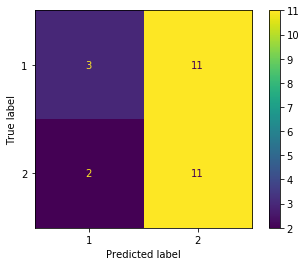

In [277]:
clsf = svm.SVC(kernel="sigmoid", C=2)   ## C=3 gave higher values of accuracy!
clsf.fit(trainset_X, trainset_Y)

y_pred = clsf.predict(testset_X)

from sklearn import metrics

accuracy = metrics.accuracy_score(testset_Y, y_pred)
precision = metrics.precision_score(testset_Y, y_pred)
recall = metrics.recall_score(testset_Y, y_pred)

print("Accuracy", accuracy)
print("Precision", precision)
print("Recall", recall)


from sklearn.metrics import confusion_matrix, plot_confusion_matrix
print(str(confusion_matrix(testset_Y, y_pred)))
plot_confusion_matrix(clsf, testset_X, testset_Y)

In [278]:
from sklearn.model_selection import GridSearchCV

In [279]:
grid_params = {
    'kernel': ['sigmoid', 'poly', 'linear', 'rbf'],
    'C': [1, 2, 3, 4]
    
    
    
}

gs_svc = GridSearchCV(svm.SVC(),
        grid_params,
        scoring='accuracy',
        cv=5
        )

gs_results = gs_svc.fit(trainset_X, trainset_Y)

In [280]:
gs_svc.best_estimator_

SVC(C=1, kernel='sigmoid')

In [281]:
gs_svc.best_score_

0.5653846153846155

In [282]:
from sklearn.svm import LinearSVC
clsf_ls = LinearSVC(dual=False, random_state=0, penalty="l1", max_iter=10000)
clsf_ls.fit(trainset_X, trainset_Y)

y_pred = clsf_ls.predict(testset_X)

from sklearn import metrics

accuracy = metrics.accuracy_score(testset_Y, y_pred)
precision = metrics.precision_score(testset_Y, y_pred)
recall = metrics.recall_score(testset_Y, y_pred)

print("Accuracy", accuracy)
print("Precision", precision)
print("Recall", recall)

Accuracy 0.37037037037037035
Precision 0.4
Recall 0.42857142857142855


### Running Logistic Regression on ABIDE 2 dataset

Accuracy 0.5925925925925926
Precision 0.7142857142857143
Recall 0.35714285714285715
[[ 5  9]
 [ 2 11]]


/home/titir/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


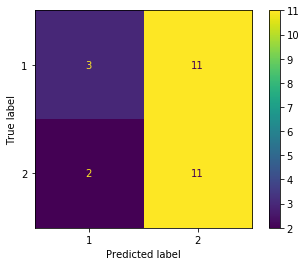

In [283]:
from sklearn.linear_model import LogisticRegression

clsf_lg = LogisticRegression(penalty='l2')
clsf_lg.fit(trainset_X, trainset_Y)

y_pred = clsf_lg.predict(testset_X)

from sklearn import metrics

accuracy = metrics.accuracy_score(testset_Y, y_pred)
precision = metrics.precision_score(testset_Y, y_pred)
recall = metrics.recall_score(testset_Y, y_pred)

print("Accuracy", accuracy)
print("Precision", precision)
print("Recall", recall)


from sklearn.metrics import confusion_matrix, plot_confusion_matrix
print(str(confusion_matrix(testset_Y, y_pred)))
plot_confusion_matrix(clsf, testset_X, testset_Y)

In [176]:
import matplotlib.pyplot as plt
import seaborn as sn


### Running a Random Forest Classifier

In [284]:
from sklearn.ensemble import RandomForestClassifier 
# TODO
clsf_rf = RandomForestClassifier()
clsf_rf.fit(trainset_X, trainset_Y)

y_pred = clsf_rf.predict(testset_X)

from sklearn import metrics

accuracy = metrics.accuracy_score(testset_Y, y_pred)
precision = metrics.precision_score(testset_Y, y_pred)
recall = metrics.recall_score(testset_Y, y_pred)

print("Accuracy", accuracy)
print("Precision", precision)
print("Recall", recall)

Accuracy 0.6296296296296297
Precision 0.7
Recall 0.5


In [285]:
grid_params_rf = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'n_estimators': [80, 90, 100, 110]
    
}

gs_rf = GridSearchCV(RandomForestClassifier(),
                        grid_params_rf,
                        scoring='accuracy')

gs_results_rf = gs_rf.fit(trainset_X, trainset_Y)
gs_rf.best_estimator_

RandomForestClassifier(max_depth=80, n_estimators=110)

In [286]:
gs_rf.best_score_

0.5935897435897436

In [287]:
from sklearn.tree import DecisionTreeClassifier 

clsf_dt = DecisionTreeClassifier() 
clsf_dt.fit(trainset_X, trainset_Y)

y_pred = clsf_dt.predict(testset_X)

from sklearn import metrics

accuracy = metrics.accuracy_score(testset_Y, y_pred)
precision = metrics.precision_score(testset_Y, y_pred)
recall = metrics.recall_score(testset_Y, y_pred)

print("Accuracy", accuracy)
print("Precision", precision)
print("Recall", recall)

Accuracy 0.5185185185185185
Precision 0.5384615384615384
Recall 0.5


### Naive Bayes

Accuracy 0.5925925925925926
Precision 0.6363636363636364
Recall 0.5


/home/titir/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


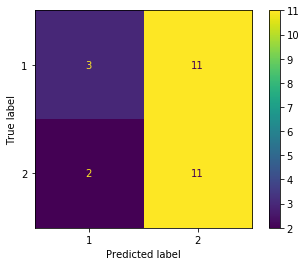

In [288]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
clsf_nb = GaussianNB() ## gives best accuracy of all the different naive bayes approaches
clsf_nb.fit(trainset_X, trainset_Y)

y_pred = clsf_nb.predict(testset_X)

from sklearn import metrics

accuracy = metrics.accuracy_score(testset_Y, y_pred)
precision = metrics.precision_score(testset_Y, y_pred)
recall = metrics.recall_score(testset_Y, y_pred)

print("Accuracy", accuracy)
print("Precision", precision)
print("Recall", recall)

plot_confusion_matrix(clsf, testset_X, testset_Y)

### KNN

In [289]:
from sklearn.neighbors import KNeighborsClassifier
from math import sqrt

k = int(sqrt(len(trainset_X)))
clsf = KNeighborsClassifier(n_neighbors=14) 
clsf.fit(trainset_X, trainset_Y)

y_pred = clsf.predict(testset_X)

from sklearn import metrics

accuracy = metrics.accuracy_score(testset_Y, y_pred)
precision = metrics.precision_score(testset_Y, y_pred)
recall = metrics.recall_score(testset_Y, y_pred)

print("Accuracy", accuracy)
print("Precision", precision)
print("Recall", recall)

Accuracy 0.5185185185185185
Precision 0.6
Recall 0.21428571428571427


Accuracy 0.6296296296296297
Precision 0.75
Recall 0.42857142857142855
[[ 6  8]
 [ 2 11]]


/home/titir/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


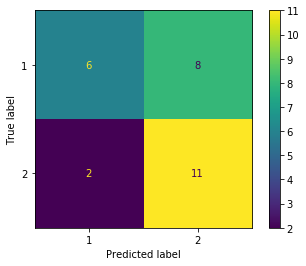

In [290]:
from sklearn.linear_model import LogisticRegression

clsf = LogisticRegression(penalty='none')
clsf.fit(trainset_X, trainset_Y)

y_pred = clsf.predict(testset_X)

from sklearn import metrics

accuracy = metrics.accuracy_score(testset_Y, y_pred)
precision = metrics.precision_score(testset_Y, y_pred)
recall = metrics.recall_score(testset_Y, y_pred)

print("Accuracy", accuracy)
print("Precision", precision)
print("Recall", recall)


from sklearn.metrics import confusion_matrix, plot_confusion_matrix
print(str(confusion_matrix(testset_Y, y_pred)))
plot_confusion_matrix(clsf, testset_X, testset_Y)

### Trying a grid search with KNN 

In [291]:
from sklearn.model_selection import GridSearchCV

k = [i for i in range(1, 15, 2)]
grid_params_knn = {
    'n_neighbors': k,
    'weights': ['uniform', 'distance'] ,
    'metric': ['minkowski', 'manhattan'] 
}

gs_knn = GridSearchCV(KNeighborsClassifier(),
        grid_params_knn,
        scoring='accuracy',
        )

gs_results_knn = gs_knn.fit(trainset_X, trainset_Y)

In [292]:
gs_knn.best_score_


0.5794871794871794

In [293]:
gs_knn.best_estimator_

KNeighborsClassifier(n_neighbors=7)

In [294]:
gs_knn.best_params_

{'metric': 'minkowski', 'n_neighbors': 7, 'weights': 'uniform'}

### MLP Classifier

In [295]:
from sklearn.neural_network import MLPClassifier, MLPRegressor, BernoulliRBM

clsf_mlp = MLPClassifier(learning_rate='adaptive', max_iter=10000)
clsf_mlp.fit(trainset_X, trainset_Y)

y_pred = clsf_mlp.predict(testset_X)

from sklearn import metrics

accuracy = metrics.accuracy_score(testset_Y, y_pred)
precision = metrics.precision_score(testset_Y, y_pred)
recall = metrics.recall_score(testset_Y, y_pred)

print("Accuracy", accuracy)
print("Precision", precision)
print("Recall", recall)

Accuracy 0.6666666666666666
Precision 0.7272727272727273
Recall 0.5714285714285714


In [299]:
grid_params_mlp = {
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'], 
    'max_iter': [1000, 10000],
    
    
    
    
}

gs_mlp = GridSearchCV(MLPClassifier(),
        grid_params_mlp,
        scoring='accuracy',
        )

gs_results_mlp = gs_mlp.fit(trainset_X, trainset_Y)

/home/titir/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/titir/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/titir/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/titir/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/titir/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692

In [297]:
gs_mlp.best_estimator_

MLPClassifier(activation='logistic', early_stopping=True, max_iter=500,
              solver='sgd')

In [298]:
gs_mlp.best_score_

0.6

### Classifiers we have right now 
* MLP
* Random Forests
* Naive Bayes
* KNN
* SVC
* Linear SVC


In [192]:
classifiers = [
gs_svc.best_estimator_, #73% accuracy
gs_rf.best_estimator_, #65% accuracy
gs_knn.best_estimator_, #62% accuracy
gs_mlp.best_estimator_] #70% accuracy



In [224]:
def find_mode_classifier_result(newX):
    X_mode = []
    
    for x in newX:
        if (len(x) == 2016):
            nv = []
            for clsf in classifiers:
                nv.append(clsf.predict([x]))

            X_features_nn.append(nv)
            #print(type(nv))
            nv_list = list(nv)
            val = sum(nv_list)
            X_mode.append(int(val/len(classifiers)))
    return (X_features_nn, X_mode)

In [227]:
(X_features_nn, y_pred_mode) = find_mode_classifier_result(testset_X)

#### Accuracy from calculating the mode of the result of all the classifiers

In [228]:
metrics.accuracy_score(testset_Y, y_pred_mode)

0.47058823529411764

In [198]:
len(X_features_nn[0])

3

### Addding a Neural Network

In [212]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, LeakyReLU
import matplotlib.pyplot as plt
%matplotlib inline

In [217]:
def build_model():
    model = Sequential()
    model.add(Dense(32, input_dim=2016, activation='tanh'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
    
    return model
    

In [218]:
model = build_model()
epochs = 100

In [219]:
from sklearn.preprocessing import normalize
X_train = np.array(newX)
Y_train = np.array(newY)

In [220]:
model.fit(X_train, Y_train, epochs=epochs)

Epoch 1/100
2/2 [==============================] - 0s 2ms/step - loss: 0.8908 - accuracy: 0.2000
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: -0.3165 - accuracy: 0.5091
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: -0.7965 - accuracy: 0.5091
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: -1.0625 - accuracy: 0.5273
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: -1.2438 - accuracy: 0.5273
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: -1.3877 - accuracy: 0.5273
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: -1.5568 - accuracy: 0.5273
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: -1.7265 - accuracy: 0.5273
Epoch 9/100
2/2 [==============================] - 0s 3ms/step - loss: -1.9038 - accuracy: 0.5273
Epoch 10/100
2/2 [==============================] - 0s 3ms/step - loss: -2.0963 - accuracy: 0.5273
Epoch 11/100
2/2 [==

In [204]:
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, OPTICS

cl = KMeans(n_clusters=2).fit(newX)
cl.labels_
ypred = cl.labels_ + 1
ypred
metrics.accuracy_score(newY, ypred)

0.38181818181818183